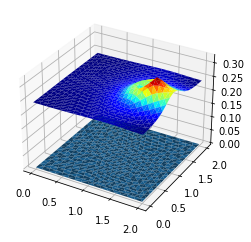

In [14]:
# Solving for menbrane thickness
# Minimizing J(h) = int2d_D (fu) dx

from fenics import *
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Create mesh and function space
mesh = Mesh('./Square.xml')
mesh = refine(mesh)
mesh = refine(mesh)
mesh = refine(mesh)

V = FunctionSpace(mesh, 'P', 1)

# Boundary condition for displacement
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, 0, boundary)

# Define variables
u = TrialFunction(V) # Displacement
p = TrialFunction(V) 
v = TestFunction(V) 
h0 = 0.25 # Thickness
h = h0
hmin = 0.1
hmax = 1
l0 = 0 # Bisecetion starting guess
l1 = 1 # Bisection starting guess 
lerr = 1e-3
hfrac = assemble(h0*dx(mesh))
F = 5
r =0.1
xc = 1.5
yc = 1

f = Expression('F*exp(-((pow(x[0]-xc, 2) + pow(x[1] - yc, 2))/(2*pow(r,2))))', degree=1, F=F, xc=xc, yc=yc, r=r)

def Max(a,b):
    return (a+b+abs(a-b))/2

def Min(a,b):
    return (a+b-abs(a-b))/2

def regularization(h):
    e = 0.01 # regularization factor
    hr = TrialFunction(V)
    a = (e**2*dot(grad(hr),grad(v))+hr*v)*dx
    L = dot(h,v)*dx
    hr = Function(V)
    solve(a==L,hr)
    return hr

max_iter = 10
dt = 0.01 # Gradient desccent variable

for i in range(max_iter):
    u = TrialFunction(V)
    a1 = h*dot(grad(u),grad(v))*dx
    L1 = dot(f,v)*dx
    u = Function(V)
    solve(a1==L1,u,bc)

    p = TrialFunction(V)
    a2 = h*dot(grad(p),grad(v))*dx
    L2 = dot(-f,v)*dx
    p = Function(V)
    solve(a2==L2,p,bc)

    dJ = dot(grad(u),grad(p))

    h = h - dt*dJ

    # proj0 = assemble(max(hmin, min(hmax,(h + l0)))*dx(mesh))
    # proj1 = assemble(max(hmin, min(hmax,(h + l1)))*dx(mesh))

    proj0 = assemble(Max(hmin, Min(hmax,(h + l0)))*dx(mesh))
    proj1 = assemble(Max(hmin,Min(hmax,(h + l1)))*dx(mesh))

    # Bisection algorithm
    ## Choose appropriate starting l0 and l1
    while (proj0>hfrac):
        l0 -= 0.1
        proj0 = assemble(Max(hmin,Min(hmax,h+l0))*dx(mesh))
    while (proj1<hfrac):
        l1 += 0.1
        proj1 = assemble(Max(hmin,Min(hmax,(h+l1)))*dx(mesh))

    ## Bisection algorithm
    while l1-l0 > lerr:
        lmid = (l0+l1)/2
        projmid = assemble(Max(hmin, Min(hmax,h+lmid))*dx(mesh))
        if projmid<hfrac:
            l0 = lmid
            proj0 = projmid
        else:
            l1 = lmid
            proj1 = projmid
    
    h = Max(hmin, Min(hmax, h + lmid))

    h = regularization(h)

plot(mesh)
plot(h)
plt.show()